# BCI



In [1]:
# Elegimos acciones...
# eeg...
# machine learning...
# ...

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

In [4]:
from BCI import *

In [5]:
# vamos a recolectar 20 datos de 2 segundos para cada acción

acciones = 2
s = 2
n = 20
electrodos = 'F3 FC5 AF3 F7 T7 P7 O1 O2 P8 T8 F8 AF4 FC6 F4'.split()
muestreo = 128
n_paquetes = s * muestreo

In [6]:
# donde vamos guardando los datos
EEG_datos = deque(maxlen=muestreo*1)
GYRO_datos = deque(maxlen=muestreo*1)

bt = BluetoothIO(EEG_datos, GYRO_datos)
eeg = EEG(EEG_datos, GYRO_datos)

mouse = WinMouse()
w,h = mouse.width, mouse.height

In [66]:
dato = eeg.get_data(1)
dato

array([[4156.66666646, 4166.41025621, 4178.97435884, 4184.10256397,
        4161.15384595, 4159.87179467, 4164.87179467, 4143.58974339,
        4171.66666653, 4167.82051262, 4181.02564089, 4191.41025628,
        4220.38461532, 4911.53846293]])

In [58]:
print(*[f"\n{electrodos[i]} {dato[0][i]:.1f}" for i in range(len(electrodos))])


F3 4158.5 
FC5 4153.1 
AF3 4156.9 
F7 4158.1 
T7 4156.9 
P7 4155.5 
O1 4156.5 
O2 4172.9 
P8 4169.2 
T8 4169.4 
F8 4173.3 
AF4 4187.7 
FC6 4226.9 
F4 4945.8


<img src="https://www.researchgate.net/profile/Marta_Molinas/publication/317579079/figure/fig2/AS:505059093868544@1497426879320/The-electrode-positions-for-the-Emotiv-EPOC-Headset.png" width="300"/>

In [68]:
# Ponerse el Emotiv y prepararse para realizar 2 acciones elegidas

X = []

for a in range(1, acciones+1):
    print(f'*'*10)
    print(f' Acción {a}')
    print(f'*'*10)
    
    sleep(2)
    for i in range(n):
        dato = eeg.get_data(muestreo * s)
        X.append(dato)
        print(i, end=' ')
        
    print('\n')

**********
 Acción 1
**********
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

**********
 Acción 2
**********
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 



In [69]:
X_ = X.copy()
X = np.array(X)

In [70]:
y = np.concatenate([np.zeros(n), np.ones(n)])

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print('Muestra train:', X_train.shape)
print('Muestra test', X_test.shape)

Muestra train: (32, 256, 14)
Muestra test (8, 256, 14)


In [55]:
X_train = Covariances().transform(X_train)
X_test = Covariances().transform(X_test)

In [56]:
# (trials, channels, samples)

n_components=3
clf = make_pipeline(XdawnCovariances(n_components),
                    TangentSpace(metric='riemann'),
                    CatBoostClassifier(iterations=20,
                                       silent=True,
                                       learning_rate=None,
                                       depth=None)
                   #LogisticRegression(solver='lbfgs')
                   )

clf.fit(X_train, y_train)
preds = clf.predict(X_test)
acc = np.mean(preds == y_test)

class_balance = np.mean(y_test == y_test[0])
class_balance = max(class_balance, 1. - class_balance)
print("Classification accuracy: %f / Chance level: %f" % (acc, class_balance))

Classification accuracy: 0.500000 / Chance level: 0.500000


In [ ]:
plot_confusion_matrix(preds, y_test, ['A', 'B']);

In [363]:
# Plot 

In [80]:
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [82]:
def do_fft(data, fs = 256):
    # Get real amplitudes of FFT (only in postive frequencies)
    fft_vals = np.absolute(np.fft.rfft(data))

    # Get frequencies for amplitudes in Hz
    fft_freq = np.fft.rfftfreq(len(data), 1.0/fs)

    eeg_bands = {'Delta': (0, 4),
                 'Theta': (4, 8),
                 'Alpha': (8, 12),
                 'Beta': (12, 30),
                 'Gamma': (30, 45)}

    # Take the mean of the fft amplitude for each EEG band
    eeg_band_fft = dict()
    for band in eeg_bands:  
        freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                           (fft_freq <= eeg_bands[band][1]))[0]
        eeg_band_fft[band] = np.mean(fft_vals[freq_ix])
    return eeg_band_fft
        
def plot_bands(eeg_bands):
    df = pd.DataFrame(columns=['band', 'val'])
    df['band'] = eeg_bands.keys()
    df['val'] = [eeg_bands[band] for band in eeg_bands]
    ax = df.plot.bar(x='band', y='val', legend=False)
    ax.set_xlabel("EEG band")
    ax.set_ylabel("Mean band Amplitude") 

In [91]:
%matplotlib widget

fig = plt.figure()
ax = plt.axes()
line, = ax.plot([], [], lw=3)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    dato = eeg.get_data(muestreo * s)
#    bandas = do_fft(sample[:,0]).items()
#    x = range(len(bandas))
#    y = [i[1] for i in bandas]
    x = range(dato.shape[0])
    y = dato[:,0]
    
    line.set_data(x, y)
    return line,

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=100, blit=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Mouse con Gyro

In [ ]:
step = 5
c = 0

print('Baseline')
sleep(2)
data = scientist.get_gyro(fs*3)

mz,mx,my,*_ = np.mean(data, axis=0)
sz,sx,sy,*_ = np.std(data, axis=0) * 0.2

print('Start')
screen.move_mouse(w//2, h//2)

for i in range(500):
    data = scientist.get_gyro(5)
    nz,nx,ny,*_ = np.mean(data, axis=0)
        
    print('Med ', mz,mx,my)
    print('Desv ',sz,sx,sy)
    print('Val ', nz,nx,ny)
    
    sleep(0.2)
    
    x, y = screen.get_mouse_position()  
    if nx < mx-sx:
        print('left')
        screen.move_mouse(x-step, y)
    elif nx > mx+sx:
        print('right')
        screen.move_mouse(x+step, y)
    if ny < my-sy:
        print('down')
        screen.move_mouse(x, y-step)
    elif ny > my+sy:
        screen.move_mouse(x, y+step)        
        print('up')
    
    if c % 20 == 0:
        screen.move_mouse(w//2, h//2)
        clear_output()
        c = 0
        
    c+=1

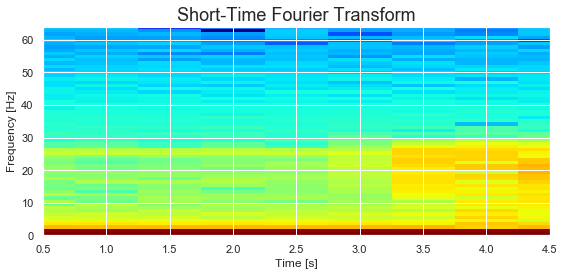

In [54]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
P, freqs, t, im = plt.specgram(data[:,1], NFFT=128, Fs=fs, noverlap = 64, cmap=plt.cm.jet)
ax1.set_title('Short-Time Fourier Transform', fontsize=18)
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Frequency [Hz]')
ax1.set_xlim(t[0], t[-1])
plt.tight_layout()

In [27]:
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

t2, freqs2 = np.meshgrid(t, freqs)

fig = plt.figure(figsize=(10, 6))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(t2, freqs2, P, rstride=1, cstride=1, cmap=plt.cm.jet,
                       linewidth=0, antialiased=False)

ax.set_xlim(t[0], t[-1])
ax.set_ylim(0, 500)
ax.set_zlim(np.min(P), np.max(P))
ax.set_xlabel('Time [s]', fontsize=12)
ax.set_ylabel('Frequency [Hz]', fontsize=12)
ax.set_zlabel('Power', fontsize=12)
ax.set_title('Short-Time Fourier Transform', fontsize=16, y=1.04)
ax.view_init(30, 60)

NameError: name 't' is not defined

In [34]:
def do_fft(data, fs = 256):
    # Get real amplitudes of FFT (only in postive frequencies)
    fft_vals = np.absolute(np.fft.rfft(data))

    # Get frequencies for amplitudes in Hz
    fft_freq = np.fft.rfftfreq(len(data), 1.0/fs)

    eeg_bands = {'Delta': (0, 4),
                 'Theta': (4, 8),
                 'Alpha': (8, 12),
                 'Beta': (12, 30),
                 'Gamma': (30, 45)}

    # Take the mean of the fft amplitude for each EEG band
    eeg_band_fft = dict()
    for band in eeg_bands:  
        freq_ix = np.where((fft_freq >= eeg_bands[band][0]) & 
                           (fft_freq <= eeg_bands[band][1]))[0]
        eeg_band_fft[band] = np.mean(fft_vals[freq_ix])
    return eeg_band_fft
        
def plot_bands(eeg_bands):
    df = pd.DataFrame(columns=['band', 'val'])
    df['band'] = eeg_bands.keys()
    df['val'] = [eeg_bands[band] for band in eeg_bands]
    ax = df.plot.bar(x='band', y='val', legend=False)
    ax.set_xlabel("EEG band")
    ax.set_ylabel("Mean band Amplitude") 

In [ ]:
data = worker()

https://github.com/CSNLWigner/emotiv-epoc/tree/master/python/notebook
https://github.com/vlawhern/arl-eegmodels
https://github.com/renaudfv/MusicWaves
https://github.com/HackTheBrain/EEG-in-Virtual-reality/tree/master/python-pure-data
https://github.com/louay-hesham/Brain-Computer-Interface
https://github.com/jajcayn/EEG-pd-sonification/blob/master/eegOSC_class.py
https://github.com/faturita/python-nerv
https://github.com/xribene/Emokit_Epoc_GUI
https://github.com/eegsynth/eegsynth/blob/master/doc/module-overview.md
https://github.com/mne-tools/mne-python
https://github.com/dalequark/emotivExperiment

https://plot.ly/ipython-notebooks/mne-tutorial/

https://discordapp.com/welcome/382301373062053888/382301373062053893/0
https://github.com/signal11/hidapi


In [ ]:
#        for e in range(len(electrodos)):
#            w = dato[:,e]
            
#        w = butter_bandpass_filter(w, 8.0, 15.0, fs, order=6)
#        freqs = np.sum(np.abs(fft(y)[0:fs//2]))        
